In [45]:
import pandas as pd
from scipy.stats import geom
import matplotlib.pyplot as plt
import numpy as np

In [46]:
#plt.rcParams['figure.autolayout'] = False
#plt.rcParams['figure.figsize'] = 10, 6
plt.rcParams['axes.labelsize'] = 18
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['font.size'] = 16
plt.rcParams['lines.linewidth'] = 2.0
plt.rcParams['lines.markersize'] = 8
plt.rcParams['legend.fontsize'] = 14

plt.rcParams['text.usetex'] = True
plt.rcParams['figure.dpi'] = 300
#plt.rcParams['font.family'] = "serif"
plt.rcParams['font.serif'] = "cm"
plt.rcParams['text.latex.preamble'] = "\usepackage{subdepth}, \usepackage{type1cm}"

In [4]:
p=0.2

In [42]:
median = -1 / np.log2(1-p)
print median

3.1062837195053903


In [31]:
def plot_dists(p1, p2):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,8))
    fig.set
    plot_geom(p1, ax1)
    plot_geom(p2, ax2)

In [30]:
def plot_geom(p, ax):
    rv = geom(p)
    x = np.arange(rv.ppf(0.01), rv.ppf(0.99))
    y = rv.pmf(x)
    mean = 1.0/p
    ax.plot(x, y, 'ob')
    ax.vlines(x, 0, y, 'b')
    tick_sample = int(len(x) / 10.0)
    ax.set_xticks(x[::tick_sample])
    ax.set_xlabel("Years")
    ax.set_ylabel("Probability")
    ax.set_title("p = {0}".format(p))
    ax.vlines(mean, 0, rv.pmf(mean), 'r', lw=4)
    ax.annotate('Average lifetime = {0} years'.format(mean), (mean, rv.pmf(mean)), (12, 12), textcoords='offset pixels', fontsize='x-large')

In [56]:
def plot_exp(p):
    rv = geom(p)
    x = np.arange(1, 50)
    y = rv.pmf(x)
    exp = np.cumsum(x*y)
    mean = 1.0/p
    fig, ax = plt.subplots(1, 1, dpi=100)
    ax.plot(x, exp, 'ob')
    ax.set_xlabel("Years")
    ax.set_ylabel("Cumulative sum of weighted lifetimes")
   

# Customer lifetime estimation from churn

Recently I was listening to Tom, our CEO, explain how we use average customer lifetime in our Return on Investment (ROI) business cases - it is one of many elements that we must estimate when building a ROI case for our customers. Tom explained how we use *1 / Churn*, in order to estimate average customer lifetime - a commonly adopted approach. For example if we know that the churn is 20%, we would estimate the average lifetime as $\frac{1}{0.2}$ = 5 years.

Listening to him, I realised, I didn't know why this was valid. It is simple to estimate and is an accepted method, but I wanted to dig into why its used.

## Defining Churn and Lifetime

To get started, its important to explain what we mean by churn. We can define churn as the probability that at the *end of a year* a customer leaves. For example, if our churn was 50% (!) then at the end of a year, we flip a coin: heads the customer churns, tails the customer renews. Obviously we can pick any timescale to consider churn over, it doesn't have to be a one year (e.g. it could be daily, weekly or monthly churn).

Clearly 50% churn is insane, so lets continue by assuming 20% churn. We can write the *probability, $P$,* of a customer churning after 1 year, *Y*, like this:

\begin{align}
P(Y = 1) & = 0.2
\end{align}

We can also ask the question - what is the probability that a customer will churn after two years? In this case they renewed in year 1 (we had a 80% chance of renewing), but they churned at the end of year 2. So the probability of churning after 2 years is:

\begin{align}
P(Y = 2) & = 0.8 \times 0.2 = 0.16 \\
\end{align}

Thus, we have a 0.16 or 16% chance of a customer churning after two years. Similarly we can ask what is the chance of a customer churning after 3 years, or even 10 years (we retain them for 10 years: 9 renewals and then they churn at the end of year 10)?

\begin{align}
P(Y = 3) & = 0.8 \times 0.8 \times 0.2 = 0.128 \\
P(Y = 10) & = 0.8 \times 0.8 \times 0.8 \times 0.8 \times 0.8 \times 0.8 \times 0.8 \times 0.8 \times 0.8 \times 0.2 = 0.027 \\
\end{align}

So we have a 12.8% chance of a customer churning after 3 years. We therefore say they had a lifetime of 3 years. We can also say their is a 2.7% chance of a customer having a 10 year lifetime. 

## A simple model for churn: the geometric distribution

The last calculation was a little tedious to write, but we can write it more generally as:

\begin{align}
P(Y=y) &= p\ (1-p)^{ y-1} && \text{for}\ y = 1, 2, 3 \dots \\
\end{align}

where $p$ is the probability of churning - a value between 0.0 and 1.0.

This is called the **geometric distribution**, sometimes called the **shifted geometric distribution**. It is a probability distribution used to model the number of trials (in our case a trial is each successive year a customer decides to stay or leave) up to an event (in our case the churn event).

To show how it related to our earlier examples, for a 20% churn probability, $p=0.2$:

\begin{align*}
P(Y=y) &= p\ (1-p)^{ y-1} \\
P(Y=y) &= 0.2\cdot (1-0.2)^{ y-1} \\
P(Y=y) &= 0.2\cdot 0.8^{ y-1} 
\end{align*}

We can plot this probability against each year - to visualise the chance of a customer churning after 1,2,3,4... years. We can also plot what this would look like if p=0.1, i.e. a 10% probability of churn:

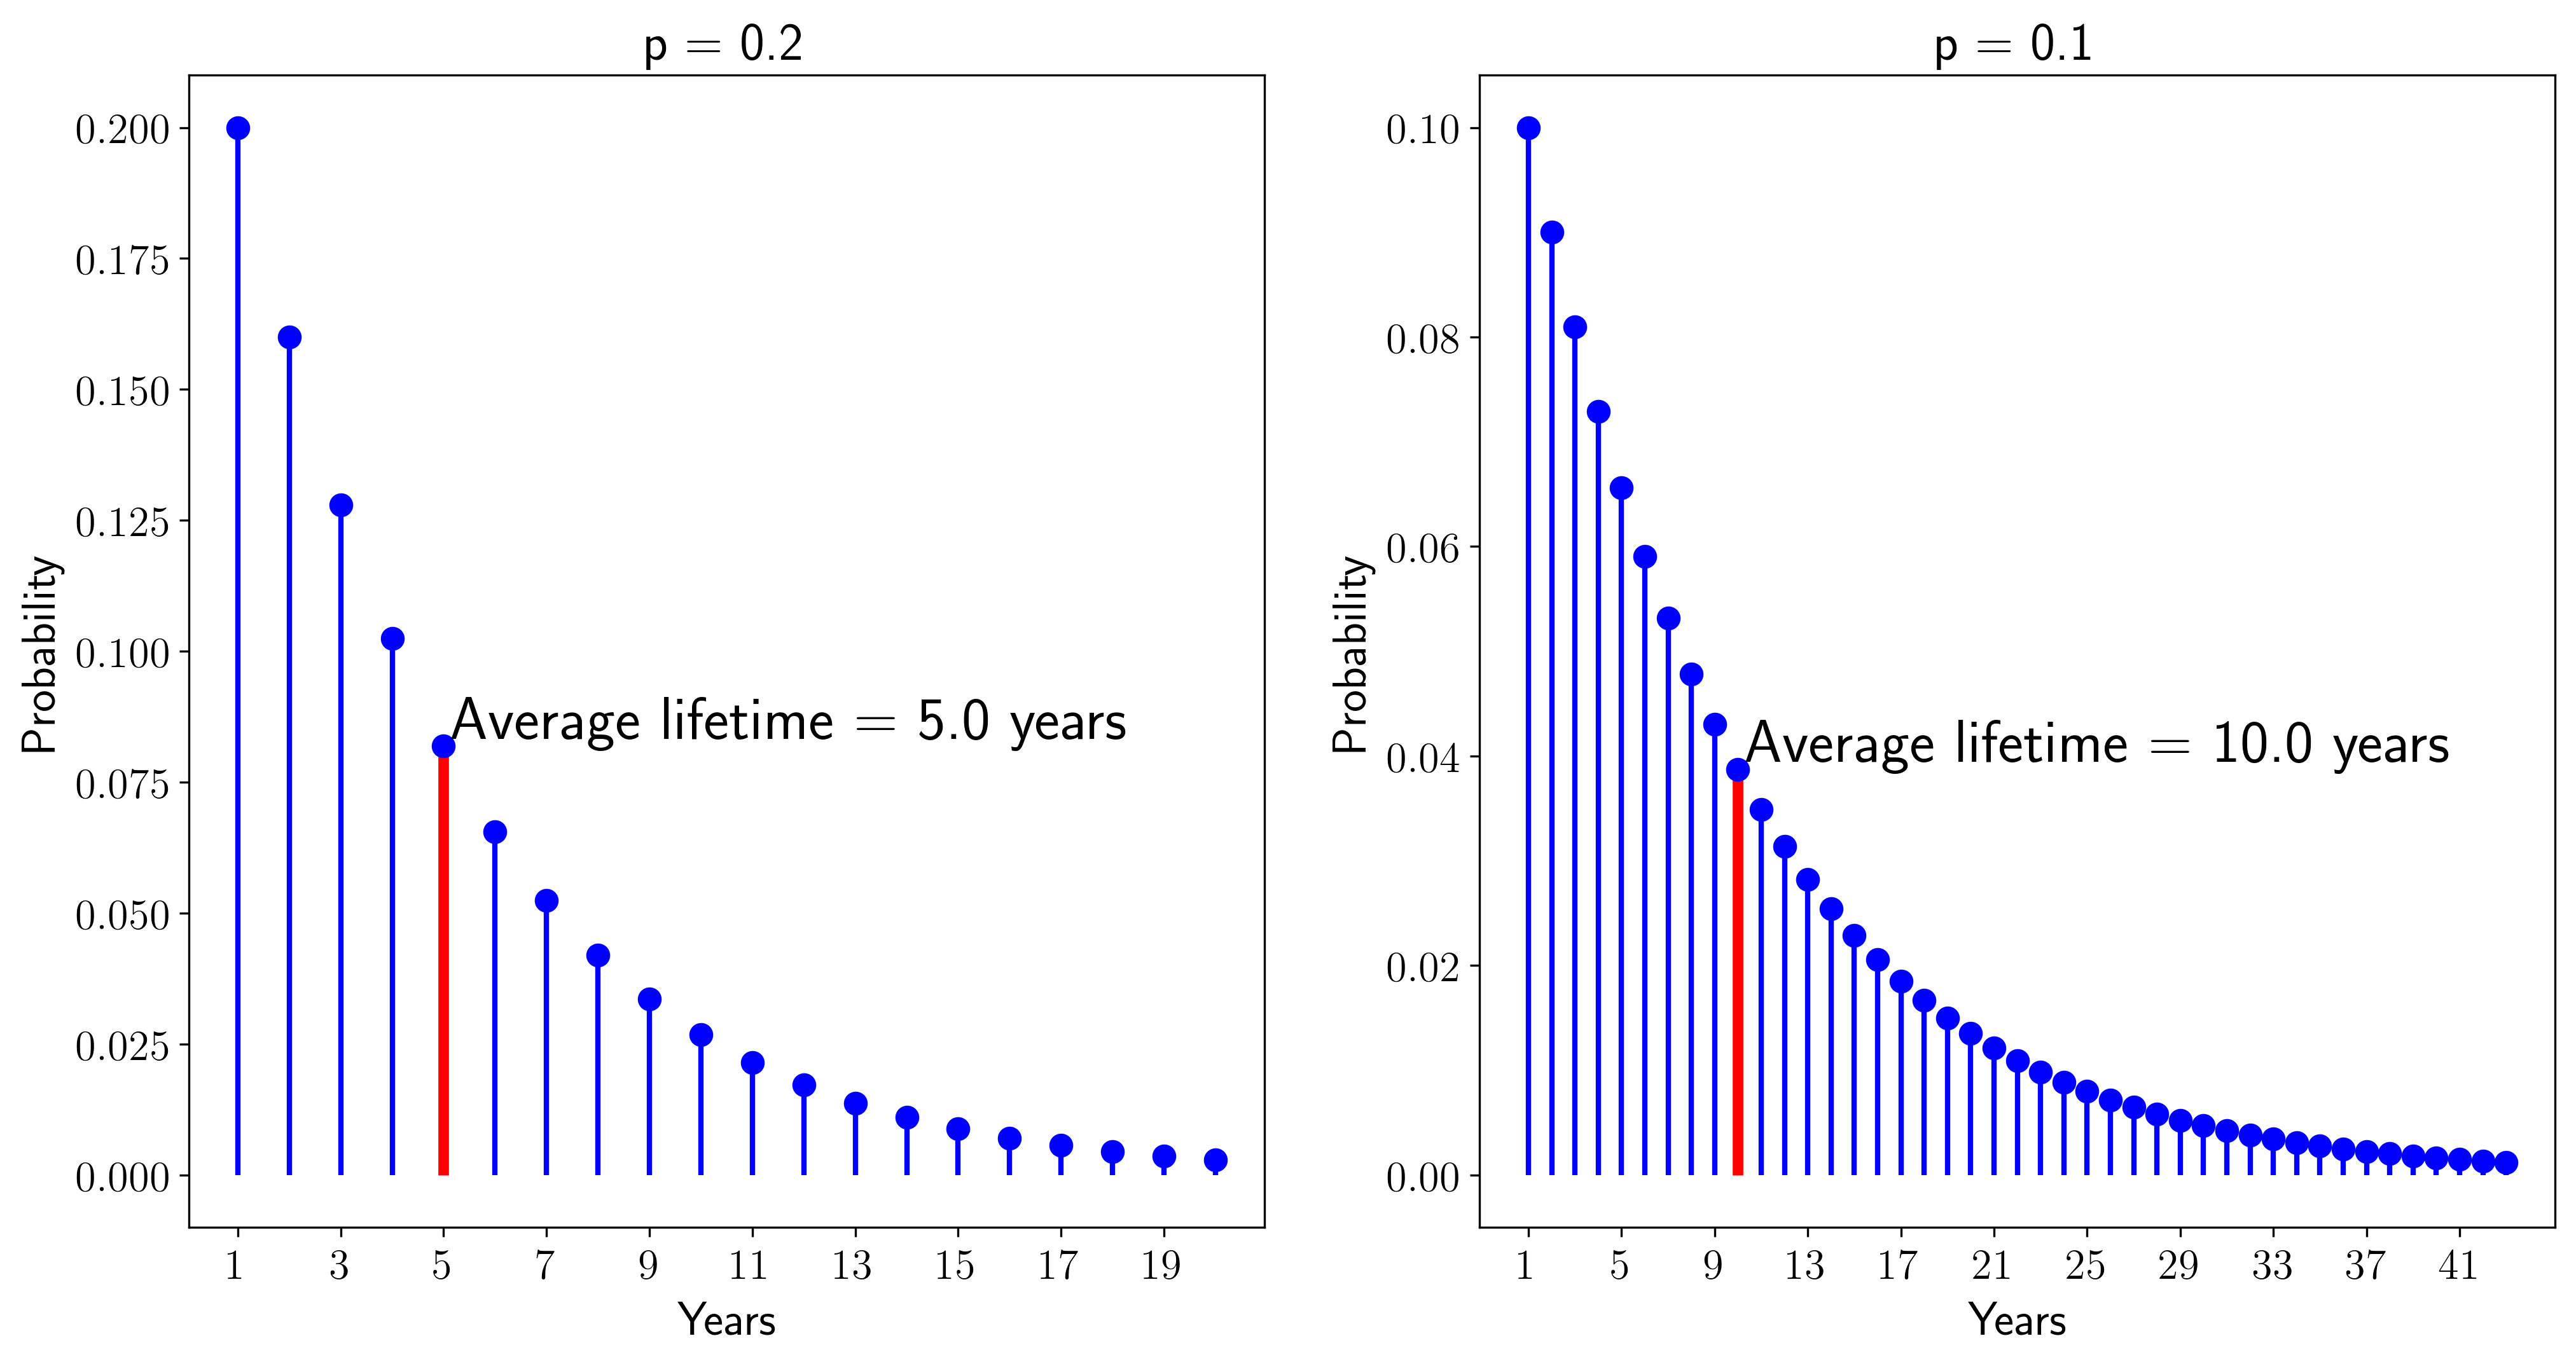

In [32]:
plot_dists(0.2, 0.1)

These distributions seem intuitive - as each year passes, the chance of a customer staying decays. What this also tells us is that the most common lifetime for a customer is 1 year - this is the *mode* of this distribution.

In the left-hand plot, as expected we can see the churn probabilities are 20% after one year and 16% after two years - as we calculated previously. The probability of retaining a customer for five years is only 8.2% and yet (perhaps unintuiatively) this is what we estimate to be the average customer lifetime! How can this be? 

The answer lies in the **long-tail** of this distribution: unlike the Normal distribution the most likely lifetime is not the same as average lifetime for the geometric distribution. A lifetime of 1 year is most likely (a 20% chance) and 5 years is only 8.2% likely. However some customers will only churn after 10 or even 20 (or even longer) years. These small chances of longer lifetimes all contribute to the average - i.e. these longer-term, loyal customers average out the shorter lifetime customers.

We can calculate the average lifetime as the **sum** of the **lifetime of a customer $\times$ the chance of a customer having that lifetime**. A simple example of such a weighted sum is the average number you get from rolling a die. The outcomes are either 1,2,4,5,6 and the chance of each outcome occurring is $\frac{1}{6}$ - hence the average score from repeatedly rolling the die is $\frac{1}{6} \times 1 + \frac{1}{6} \times 2 \dots = 3.5$.

The first few sums for average customer lifetime are:

\begin{align}
\text{Average Lifetime} &=  P(Y=1) \times 1 +  P(Y=2) \times 2 + P(Y=3) \times 3 \dots \\
\text{Average lifetime} &= 0.2 \times 1 + 0.16 \times 2 + 0.128 \times 3 \dots \\
\text{Average liftime} &= 0.2 + 0.32 + 0.384 + 0.4096 \dots
\end{align}

This sum goes on forever, but we can plot how this sum *converges* with each weighted contribution:

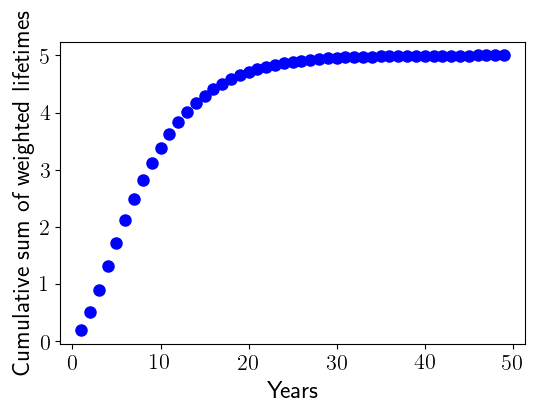

In [57]:
plot_exp(0.2)

As expected this average settles to 5 years after the contributions from ~30 years i.e. the average of all possible lifetimes is 5 years! It turns out we can show that this sum is **exactly** 5 years - but in order to do that we'll need to get into some maths.

## Summary

Before we get to that, its worth explaining the limitations of using the geometric distribution.

 Firstly this model assumes that the probability a customer will churn is always 20% **regardless** of previous years outcomes. This is the independence assumption - it intuitively feels too simple - maybe you'd expect your first year churn to be 20%, but if a customer renewed in year 1, you'd expect the chance of churning in year 2 to be related to outcome of year 1. Unlike flipping a coin, where the outcome of each flip is completely independent of the previous flip - the chances of a customer churning each year are not independent events.

The second assumption is that the churn probability is always 20% - again maybe this depends on the type of customer e.g. perhaps smaller customers churn more easily. We may have many such pieces of information about a customer e.g. how engaged they were, when they last responded to an email, how rapidly they've grown. These 'signals' can't be incorporated into the simple model above.

Finally the possible outcomes each year might not be simply customer churns vs customer renews - perhaps some customers become dormant or go out of business - maybe we want to model these outcomes differently.

A more flexible approach, e.g. using Machine Learning, can help overcome these limitations - allowing you to incorporate additional data or signals and train a more sophisticated model of churn.

However, when building business cases, its perfectly acceptable to use $\frac{1}{churn}$ as an estimate of average customer lifetime.

If you've got this far, you've hopefully learnt a bit about probability distributions, expectations and infinite sums, you may also be interested in how to exactly show

## Showing that the average lifetime is exactly $\frac{1}{p}$

In order to calculate the Average Customer Lifetime, we need to evaluate this sum to infinity. This weighted sum is called the mean or **expectation, E** of the probability distribution, it is given by:

\begin{align}
E[Y] &= \sum_{y=1}^{\infty} P(Y=y)\cdot y 
\end{align}

To remind ourselves, we are trying to prove that this expectation is evaluates to $\frac{1}{p}$ i.e. $\frac{1}{churn}$. Lets work through this, substituting in for $P(Y=y)$ from earlier. 

\begin{align}
E[Y] &= \sum_{y=1}^{\infty} p\ (1-p)^{ y-1}y \\
E[Y] &= p \sum_{y=1}^{\infty} (1-p)^{ y-1}y 
\end{align}

Lets substitute $q = 1-p$ for convenience:

\begin{align}
E[Y] &= p \sum_{y=1}^{\infty} q^{ y-1}y 
\end{align}

The trick here is to recognise that the summation can be replaced by a derivative of another summation, using THIS fact.

\begin{equation*}
E[Y] = p \frac{d}{dq} \Big( \sum_{y=0}^{\infty} q^{ y} \Big) 
\end{equation*}

Now, we can recognise we have a geometric series. As we know that $q < 1$, the geometric series $\sum_{y=0}^{\infty} q^{y}$ will converge to $\frac{1}{1-q}$ or $(1-q)^{-1}$
We can subsitute this for the summation:

\begin{equation*}
E[Y] = p \frac{d}{dq} \big( (1-q)^{-1} \big) 
\end{equation*}

If we evaluate the derivative and simplify:

\begin{align*}
E[Y] &= p \big( \text{-1} \cdot \text{-1}\cdot(1-q)^{-2} \big) \\
E[Y] &= \frac{p}{(1-q)^{2}} \\
E[Y] &= \frac{p}{(1-(1-p))^{2}} \\
E[Y] &= \frac{p}{p^{2}} \\
E[Y] &= \frac{1}{p}
\end{align*}

Hence, we know for the geometric distribution, the mean is $\frac{1}{p}$ and hence why it is valid to take this value when estimating average customer lifetime from churn.